Soccer is a captivating sport, and with so many tournaments happening across the big 5 leagues, I think it would be interesting to simulate what would happen between teams. There are many factors that can affect a game of soccer. I think that it would be interesting if AI was able to predict the winner of a tournament for example the champions league based off of rosters and things like injury likelihood, and goals scored.


*   Can AI predict the outcome of the 2023 champions league?
*   How accurate were the score predictions of each match?

Got all the data from api football since our initial web scraping approach got patched after part 2 of the project was due. We are using stats like expected goals, home win rate, away win rate, and other stats to predict the scores of each champions league playoff match in 2023.



In [1]:
# Imports
import requests
import json
from bs4 import BeautifulSoup
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# URL to scrape
API_KEY = "b19c7a79f85f9a666e833c18b8a1c74e"
BASE_URL = "https://v3.football.api-sports.io/"

In [3]:
# Headers for authentication
headers = {
    'x-apisports-key': API_KEY
}

In [4]:
def get_champions_league_standings(seasons=[2020, 2021, 2022, 2023]):
    """
    Fetches UEFA Champions League group stage standings for multiple seasons.

    Args:
    seasons (list): A list of seasons (years) to fetch data for.

    Returns:
    DataFrame: A DataFrame containing the standings for the specified seasons.
    """
    all_standings = []  # List to store standings data across seasons

    for season in seasons:
        url = BASE_URL + "standings"
        params = {
            'season': season,  # Fetch data for the given season
            'league': '2',     # UEFA Champions League ID
        }

        response = requests.get(url, headers=headers, params=params)

        if response.status_code == 200:
            standings_data = response.json()
            for league in standings_data['response']:
                for group_standing in league['league']['standings']:
                    for team in group_standing:
                        team_data = {
                            'Season': season,
                            'Team': team['team']['name'],
                            'Group': team['group'],
                            'Position': team['rank'],
                            'Points': team['points'],
                            'Goals For': team['all']['goals']['for'],
                            'Goals Against': team['all']['goals']['against'],
                            'Goal Difference': team['goalsDiff'],
                            'Form': team['form']
                        }
                        all_standings.append(team_data)
        else:
            print(f"Error fetching data for season {season}: {response.status_code}")

    standings_df = pd.DataFrame(all_standings)
    return standings_df

In [5]:
def fetch_champions_league_matches(seasons=[2020, 2021, 2022, 2023]):
    """
    Fetches UEFA Champions League match data for multiple seasons.

    Args:
    seasons (list): A list of seasons (years) to fetch match data for.

    Returns:
    list: A list of match data dictionaries.
    """
    all_matches = []  # List to store match data

    for season in seasons:
        url = BASE_URL + "fixtures"
        params = {
            'season': season,
            'league': '2',  # UEFA Champions League ID
        }

        response = requests.get(url, headers=headers, params=params)

        if response.status_code == 200:
            all_matches.extend(response.json()['response'])  # Append matches to the list
        else:
            print(f"Error fetching data for season {season}: {response.status_code}")

    return all_matches

In [6]:
def calculate_elo_rating(team_rating, opponent_rating, result, K=20):
    """
    Calculates the new Elo rating for a team after a match.

    Args:
    team_rating: The current Elo rating of the team.
    opponent_rating: The current Elo rating of the opponent team.
    result: The result of the match (1 for win, 0.5 for draw, 0 for loss).
    K: The constant factor controlling the impact of each match.

    Returns:
    new_rating: The new Elo rating for the team after the match.
    """
    # Calculate expected score (E) for the team
    expected_score = 1 / (1 + 10 ** ((opponent_rating - team_rating) / 400))

    # Actual score (1 for win, 0.5 for draw, 0 for loss)
    actual_score = result

    # Update the team's Elo rating
    new_rating = team_rating + K * (actual_score - expected_score)

    return new_rating

In [7]:
def update_elo_ratings(matches, initial_elo_rating=1500, K=20):
    """
    Updates the Elo ratings based on match results.

    Args:
    matches (list): A list of match dictionaries.
    initial_elo_rating (int): Default Elo rating for new teams (1500).
    K (int): K-factor controlling rating change sensitivity (default 20).

    Returns:
    dict: A dictionary mapping (team, season) to their updated Elo ratings.
    """
    elo_ratings = {}

    for match in matches:
        # Extract season, teams, and scores
        season = match['league']['season']
        home_team = match['teams']['home']['name']
        away_team = match['teams']['away']['name']
        home_score = match['goals']['home']
        away_score = match['goals']['away']

        # Ensure scores are valid (skip match if data is missing)
        if home_score is None or away_score is None:
            continue

        # Determine match result for Elo calculation
        if home_score > away_score:
            home_result, away_result = 1, 0  # Home win
        elif home_score < away_score:
            home_result, away_result = 0, 1  # Away win
        else:
            home_result, away_result = 0.5, 0.5  # Draw

        # Initialize Elo ratings for new teams in the given season
        if (home_team, season) not in elo_ratings:
            elo_ratings[(home_team, season)] = initial_elo_rating
        if (away_team, season) not in elo_ratings:
            elo_ratings[(away_team, season)] = initial_elo_rating

        # Retrieve current ratings
        home_rating = elo_ratings[(home_team, season)]
        away_rating = elo_ratings[(away_team, season)]

        # Update Elo ratings
        new_home_rating = calculate_elo_rating(home_rating, away_rating, home_result, K)
        new_away_rating = calculate_elo_rating(away_rating, home_rating, away_result, K)

        # Store updated ratings
        elo_ratings[(home_team, season)] = new_home_rating
        elo_ratings[(away_team, season)] = new_away_rating

    return elo_ratings

In [8]:
# Fetch standings and extract group stage teams
standings_df = get_champions_league_standings()

# Fetch matches data
matches = fetch_champions_league_matches()

# Update Elo ratings for group stage matches
elo_ratings = update_elo_ratings(matches)

# Convert the Elo ratings into a DataFrame
# Since elo_ratings has a dictionary structure with (team, season) as the key, we can flatten it
elo_data = [{"Team": team, "Season": season, "Elo Rating": elo} for (team, season), elo in elo_ratings.items()]

# Create the DataFrame
elo_df = pd.DataFrame(elo_data)

# Sort the DataFrame by Elo Rating (highest first)
elo_df = elo_df.sort_values(by='Season', ascending=False).reset_index(drop=True)

# Display the top teams by Elo rating
elo_df

,Team,Season,Elo Rating
0,Inter,2023,1526.745766
1,Real Sociedad,2023,1505.751798
2,Lens,2023,1500.725099
3,Sevilla,2023,1462.952755
4,Napoli,2023,1501.040460
...,...,...,...
310,Qarabag,2020,1520.000000
311,Inter Club d'Escaldes,2020,1490.000000
312,Drita,2020,1500.000000
313,Linfield,2020,1509.424989


In [9]:
 # Merge standings and Elo into one DataFrame
new_df = standings_df.merge(elo_df, on='Team', how='left')

# Sort by group and position
new_df = new_df.sort_values(by=['Group', 'Position']).reset_index(drop=True)

new_df.rename(columns={'Season_x': 'Season'}, inplace=True)

# Display the DataFrame
new_df

,Season,Team,Group,Position,Points,Goals For,Goals Against,Goal Difference,Form,Season_y,Elo Rating
0,2021,Manchester City,Group A,1,12,18,10,8,LWWWL,2023,1572.972815
1,2021,Manchester City,Group A,1,12,18,10,8,LWWWL,2022,1576.963682
2,2021,Manchester City,Group A,1,12,18,10,8,LWWWL,2021,1534.635376
3,2021,Manchester City,Group A,1,12,18,10,8,LWWWL,2020,1586.464487
4,2022,Napoli,Group A,1,15,20,6,14,LWWWW,2023,1501.040460
...,...,...,...,...,...,...,...,...,...,...,...
386,2020,RB Leipzig,UEFA Champions League: Group H,2,12,11,12,-1,WWLWL,2020,1499.950326
387,2020,Manchester United,UEFA Champions League: Group H,3,9,15,10,5,LLWLW,2023,1476.390769
388,2020,Manchester United,UEFA Champions League: Group H,3,9,15,10,5,LLWLW,2021,1509.545392
389,2020,Manchester United,UEFA Champions League: Group H,3,9,15,10,5,LLWLW,2020,1497.864639


In [10]:
# Convert list of dictionaries into a DataFrame
matches_df = pd.DataFrame(matches)

# Extract home and away team names
matches_df["HomeTeam"] = matches_df["teams"].apply(lambda x: x["home"]["name"])
matches_df["AwayTeam"] = matches_df["teams"].apply(lambda x: x["away"]["name"])

# Extract home and away goals (handling missing values)
matches_df["HomeGoals"] = matches_df["goals"].apply(lambda x: x.get("home", 0) if isinstance(x, dict) else 0)
matches_df["AwayGoals"] = matches_df["goals"].apply(lambda x: x.get("away", 0) if isinstance(x, dict) else 0)

# Aggregate total goals for each team
home_goals = matches_df.groupby("HomeTeam")["HomeGoals"].sum()
away_goals = matches_df.groupby("AwayTeam")["AwayGoals"].sum()

# Combine and sort goal totals
total_goals = home_goals.add(away_goals, fill_value=0).sort_values(ascending=False).head(5)

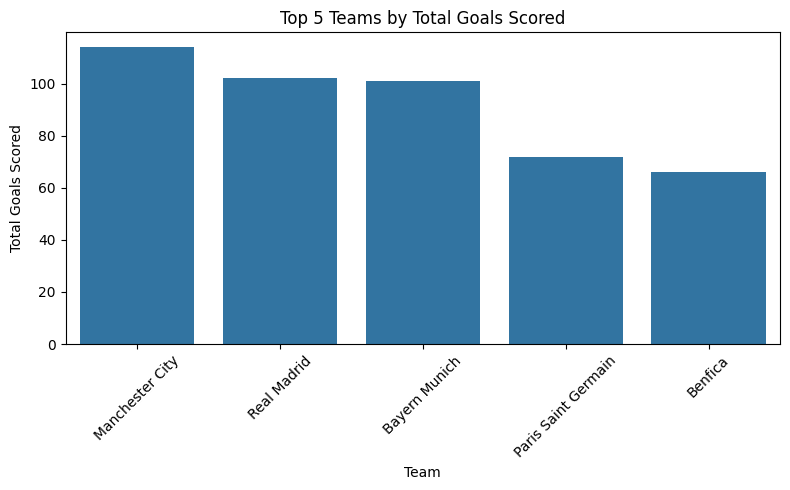

In [11]:
# bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x=total_goals.index, y=total_goals.values)
plt.xlabel("Team")
plt.ylabel("Total Goals Scored")
plt.title("Top 5 Teams by Total Goals Scored")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

A bar graph representing the top 5 teams in terms of goals scored in the champions league. This shows us who we should be expecting to win lots of the champions league matches in theory.

In [12]:
# Step 1: Total goals scored and conceded
home_goals = matches_df.groupby("HomeTeam")["HomeGoals"].sum()
away_goals = matches_df.groupby("AwayTeam")["AwayGoals"].sum()
total_goals = home_goals.add(away_goals, fill_value=0)

home_conceded = matches_df.groupby("HomeTeam")["AwayGoals"].sum()
away_conceded = matches_df.groupby("AwayTeam")["HomeGoals"].sum()
total_conceded = home_conceded.add(away_conceded, fill_value=0)

# Step 2: Create DataFrame
team_stats = pd.DataFrame({
    "Team": total_goals.index,
    "GoalsScored": total_goals.values,
    "GoalsConceded": total_conceded.values
})
team_stats["GoalDiff"] = team_stats["GoalsScored"] - team_stats["GoalsConceded"]

<ipython-input-13-84efcd0be657>:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


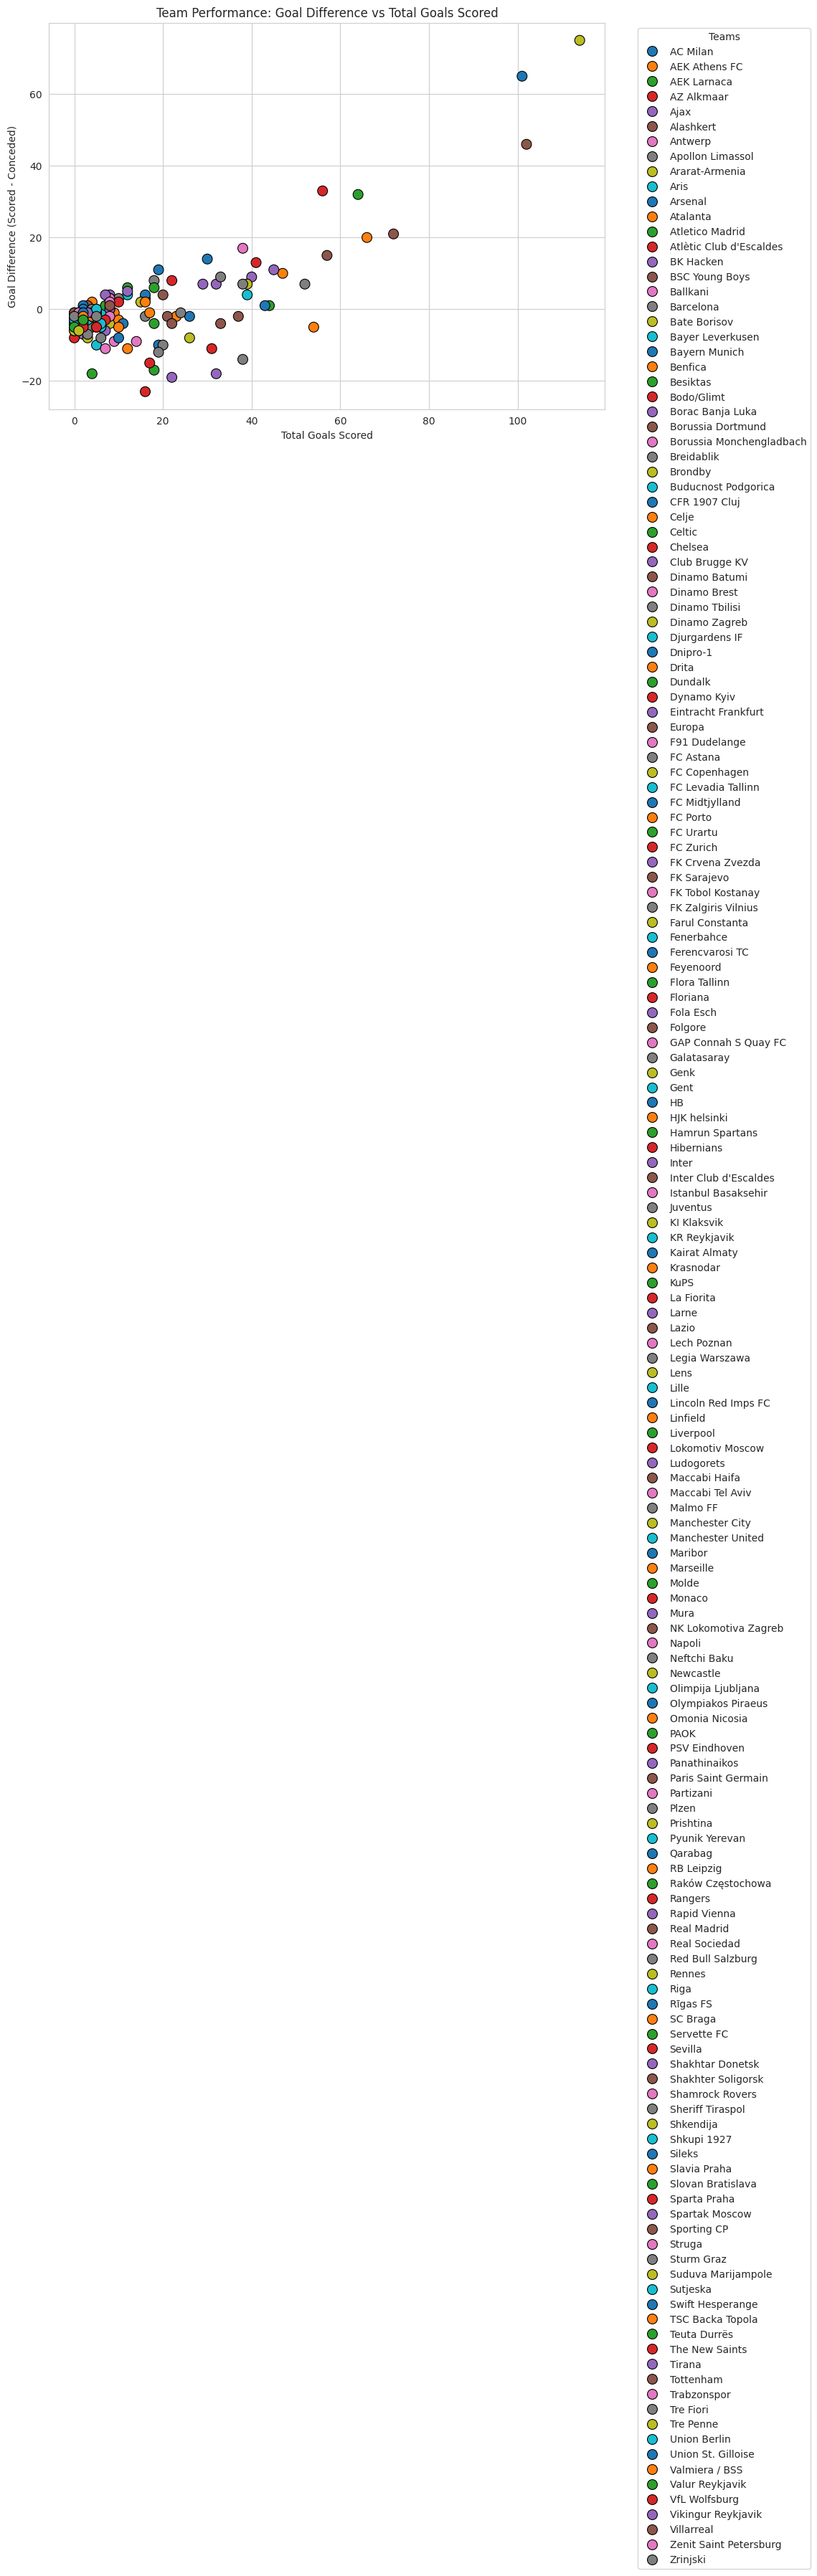

In [13]:
plt.figure(figsize=(10, 7))
sns.set_style("whitegrid")

sns.scatterplot(
    data=team_stats,
    x="GoalsScored",
    y="GoalDiff",
    hue="Team",
    s=100,
    edgecolor="black",
    palette="tab10"
)

plt.title("Team Performance: Goal Difference vs Total Goals Scored")
plt.xlabel("Total Goals Scored")
plt.ylabel("Goal Difference (Scored - Conceded)")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Teams")
plt.tight_layout()
plt.show()

This graph shows the spread of how many goals each team scored versus their overall goal difference (goals scored minus goals conceded). The teams that score more and also concede less are expected to perform better overall, so this visualization highlights both offensive firepower and defensive effectiveness.

Teams in the top-right → High goal scorers with strong defenses (well-rounded and dominant teams).

Teams with high goals but low or negative goal difference → Offensively strong but defensively weak (score a lot but concede too much).

Teams with low goals and poor goal difference → Struggling teams with both low scoring and high concession (poor performance overall).

#Machine Learning

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.metrics import r2_score
import numpy as np
import math
from sklearn.metrics import confusion_matrix, classification_report

## Manual KNN predictions for a single match


In [15]:
def euclidean_distance(x1, x2):
  """
  Calculate the Euclidean distance between two data points.

  Args:
      x1 (numpy array): First data point.
      x2 (numpy array): Second data point.

  Returns:
      float: Euclidean distance between the two data points.
  """
  return np.sqrt(np.sum((x1 - x2)**2))

In [16]:
def knn(X_train, y_train, X_test, k=3):
  """
  K-Nearest Neighbors classifier.

  Args:
      X_train (numpy array): Training data features.
      y_train (numpy array): Training data labels.
      X_test (numpy array): Test data features.
      k (int, optional): Number of nearest neighbors. Default is 3.

  Returns:
      numpy array: Predicted labels for the test data.
  """
  predictions = []

  for test_point in X_test:
      # 3. Calculate distances between the test point and all training points
      distances = [euclidean_distance(test_point, x_train) for x_train in X_train]

      # 4. Sort distances and get indices of the K nearest neighbors
      k_indices = np.argsort(distances)[:k]

      # 5. Get the labels (y values) of the K nearest neighbors
      k_nearest_labels = [y_train[i] for i in k_indices]

      # 6. Predict by majority vote (mode of the nearest labels)
      vote = np.bincount(k_nearest_labels).argmax()
      predictions.append(vote)

  return np.array(predictions)

In [17]:
def extract_match_results(matches):
  """
  Extracts teams, match results, and season from API response and creates a DataFrame.

  Args:
  matches (list): List of match dictionaries from API response.

  Returns:
  pd.DataFrame: DataFrame with columns ['season', 'home_team', 'away_team', 'result']
  """
  match_data = []

  for match in matches:
      season = match['league']['season']
      home_team = match['teams']['home']['name']
      away_team = match['teams']['away']['name']
      home_goals = match['goals']['home']
      away_goals = match['goals']['away']

      # Encoding result: 1 for win, 0 for loss, 2 for draw
      if home_goals > away_goals:
          result = 1  # Home win
      elif home_goals < away_goals:
          result = 0  # Away win
      else:
          result = 2  # Draw

      match_data.append({'season': season, 'home_team': home_team, 'away_team': away_team, 'result': result})

  return pd.DataFrame(match_data)

In [18]:
def one_hot_encode_team(team, team_to_idx):
    one_hot = np.zeros(len(team_to_idx))
    one_hot[team_to_idx[team]] = 1
    return one_hot

In [19]:
matches = fetch_champions_league_matches()
match_data = extract_match_results(matches)

In [22]:
def prepare_data(match_data_df, elo_df):
  """
  Prepare the training data for KNN by merging match data and Elo ratings.

  Args:
      match_data_df (pd.DataFrame): DataFrame containing match data with columns
                                    ['season', 'home_team', 'away_team', 'result'].
      elo_df (pd.DataFrame): DataFrame containing Elo ratings for each team by season.

  Returns:
      tuple: A tuple containing:
          - X_train (np.ndarray): The prepared feature matrix for training.
          - y_train (np.ndarray): The label array for training (match result).
          - team_to_idx (dict): A dictionary mapping team names to indices for one-hot encoding.
  """

  # One-hot encoding of team names
  teams = list(set(match_data_df['home_team'].unique()) | set(match_data_df['away_team'].unique()))
  team_to_idx = {team: idx for idx, team in enumerate(teams)}

  # Merge Elo ratings for Home and Away Teams
  home_elo_df = pd.merge(match_data_df, elo_df, left_on=['home_team', 'season'], right_on=['Team', 'Season'], how='left')
  away_elo_df = pd.merge(home_elo_df, elo_df, left_on=['away_team', 'season'], right_on=['Team', 'Season'], how='left', suffixes=('_home', '_away'))

  # Drop unnecessary 'Team' columns
  away_elo_df = away_elo_df.drop(columns=['Team_home', 'Team_away'])

  # Calculate the result (1 = Win, 0 = Loss, 2 = Draw)
  def get_result(row):
      if row['result'] == 0:
          return 0  # Loss
      elif row['result'] == 1:
          return 1  # Win
      else:
          return 2  # Draw

  away_elo_df['Result'] = away_elo_df.apply(get_result, axis=1)

      # Prepare features: Combine Elo ratings and one-hot encoded team names
  X_train = []
  for _, row in away_elo_df.iterrows():
      home_team_encoded = one_hot_encode_team(row['home_team'], team_to_idx)
      away_team_encoded = one_hot_encode_team(row['away_team'], team_to_idx)
      features = np.concatenate([home_team_encoded, away_team_encoded, [row['Elo Rating_home'], row['Elo Rating_away']]])
      X_train.append(features)

  X_train = np.array(X_train)
  y_train = away_elo_df['Result'].values  # Match result (Win, Loss, Draw)

  return X_train, y_train, team_to_idx

In [23]:
def knn_predict(X_train, y_train, X_test, k=3):
    """
    Predict the class label for a given test point using K-Nearest Neighbors.

    Args:
    X_train: Array of Feature matrix for training data
    y_train: Array of labels for training data
    X_test: Array of Feature vector for the test match
    k: Number of nearest neighbors for KNN

    Returns:
    most_common: Tuple of Predicted class label (1 = Win, 0 = Loss, 2 = Draw)
    """
    def euclidean_distance(point1, point2):
        """
        Calculate the Euclidean distance between two points.
        """
        return np.sqrt(np.sum((point1 - point2) ** 2))

    # Calculate distances between the test point and all training points
    distances = []
    for i in range(len(X_train)):
        dist = euclidean_distance(X_test, X_train[i])
        distances.append((dist, i))

    # Sort by distance and select the k closest
    distances.sort(key=lambda x: x[0])

    # Get the labels of the k nearest neighbors
    nearest_neighbors = [y_train[distances[i][1]] for i in range(k)]

    # Find the most common label (win, loss, or draw)
    most_common = np.bincount(nearest_neighbors).argmax()

    return most_common

In [24]:
def match_prediction(match_data_df, elo_df, home_team, away_team, home_elo, away_elo, k=3):
    """
    Prepare the data and predict the match result for a given test match.

    Args:
        match_data_df (pd.DataFrame): DataFrame containing match data with columns
                                      ['season', 'home_team', 'away_team', 'result'].
        elo_df (pd.DataFrame): DataFrame containing Elo ratings for each team by season.
        home_team (str): Home team for prediction.
        away_team (str): Away team for prediction.
        home_elo (float): Elo rating of the home team.
        away_elo (float): Elo rating of the away team.
        k (int): Number of nearest neighbors for KNN.

    Returns:
        int: Predicted result (1 = Win, 0 = Loss, 2 = Draw).
    """
    # Prepare the data for KNN
    X_train, y_train, team_to_idx = prepare_data(match_data_df, elo_df)

    # Test match: Encode the teams and their Elo ratings
    X_test = np.concatenate([
        one_hot_encode_team(home_team, team_to_idx),  # Home team
        one_hot_encode_team(away_team, team_to_idx),  # Away team
        [home_elo, away_elo]  # Elo ratings for both teams
    ])

    # Predict the result for the test match using KNN
    result = knn_predict(X_train, y_train, X_test, k=k)

    # Determine the winner based on the prediction result
    if result == 1:
        winner = home_team  # Home team won
    elif result == 0:
        winner = away_team  # Away team won
    elif result == 2:
        winner = 'Draw'  # Draw

    return winner

In [25]:
def predict_all_2023_matches(match_data_df, elo_df, k=3):
    """
    Predict the results for all the 2023 Champions League matches using KNN.

    Args:
        match_data_df (pd.DataFrame): DataFrame containing match data with columns
                                      ['season', 'home_team', 'away_team', 'result'].
        elo_df (pd.DataFrame): DataFrame containing Elo ratings for each team by season.
        k (int): Number of nearest neighbors for KNN.

    Returns:
        pd.DataFrame: DataFrame containing predictions for all 2023 matches.
    """
    # Filter data for 2023 season
    matches_2023 = match_data_df[match_data_df['season'] == 2023]

    # Prepare the training data (same as before, merging Elo ratings, etc.)
    X_train, y_train, team_to_idx = prepare_data(match_data_df, elo_df)

    # Prepare to store the predictions
    predictions = []

    for _, match in matches_2023.iterrows():
        home_team = match['home_team']
        away_team = match['away_team']

        # Get Elo ratings for both teams in the 2023 season
        home_elo = elo_df[(elo_df['Team'] == home_team) & (elo_df['Season'] == 2023)]['Elo Rating'].values[0]
        away_elo = elo_df[(elo_df['Team'] == away_team) & (elo_df['Season'] == 2023)]['Elo Rating'].values[0]

        # One-hot encode teams and create the feature vector for the test match
        home_team_encoded = one_hot_encode_team(home_team, team_to_idx)
        away_team_encoded = one_hot_encode_team(away_team, team_to_idx)
        features = np.concatenate([home_team_encoded, away_team_encoded, [home_elo, away_elo]])

        # Predict the result for the current match
        prediction = knn_predict(X_train, y_train, features, k)
        predictions.append({
            'home_team': home_team,
            'away_team': away_team,
            'predicted_result': prediction  # 1 = Win, 0 = Loss, 2 = Draw
        })

    # Convert predictions to DataFrame
    predictions_df = pd.DataFrame(predictions)
    return predictions_df

In [26]:
def grade_predictions(predictions_df, match_data_df):
    """
    Grade the predictions by comparing predicted results with the actual match results.

    Args:
        predictions_df (pd.DataFrame): DataFrame containing predicted results for all 2023 matches.
        match_data_df (pd.DataFrame): DataFrame containing actual match data (including 'result' column).

    Returns:
        dict: Dictionary containing accuracy and classification report metrics.
    """
    # Merge predictions with actual match results (for 2023 season)
    matches_2023 = match_data_df[match_data_df['season'] == 2023]
    merged_df = pd.merge(predictions_df, matches_2023, on=['home_team', 'away_team'], how='inner')

    # Actual results (1 = Win, 0 = Loss, 2 = Draw)
    actual_results = merged_df['result'].values

    # Predicted results
    predicted_results = merged_df['predicted_result'].values

    # Calculate accuracy
    accuracy = accuracy_score(actual_results, predicted_results)

    # Classification Report (precision, recall, f1-score)
    class_report = classification_report(actual_results, predicted_results, target_names=['Loss', 'Draw', 'Win'])

    # Return evaluation metrics

    return  class_report

In [27]:
def confusion_matrix_plot(y_true, y_pred):
    """
    Generate a confusion matrix and display it as a heatmap.

    Args:
    y_true: True labels (numpy array).
    y_pred: Predicted labels (numpy array).
    """
    # Calculate confusion matrix
    matrix = np.zeros((3, 3), dtype=int)
    for true, pred in zip(y_true, y_pred):
        matrix[true, pred] += 1

    # Create a heatmap for the confusion matrix
    plt.figure(figsize=(6, 5))
    plt.imshow(matrix, cmap='Blues', interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.colorbar()

    # Set axis labels
    tick_marks = np.arange(3)
    plt.xticks(tick_marks, ['Win (1)', 'Loss (0)', 'Draw (2)'])
    plt.yticks(tick_marks, ['Win (1)', 'Loss (0)', 'Draw (2)'])

    # Add text annotations inside the matrix
    for i in range(3):
        for j in range(3):
            plt.text(j, i, str(matrix[i, j]), horizontalalignment='center', verticalalignment='center', fontsize=14)

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

                   home_team            away_team  predicted_result
0    Atlètic Club d'Escaldes  Buducnost Podgorica                 0
1                  Tre Penne           Breidablik                 2
2        Buducnost Podgorica           Breidablik                 0
3                  FC Urartu             Zrinjski                 0
4        Lincoln Red Imps FC              Qarabag                 0
..                       ...                  ...               ...
209            Bayern Munich          Real Madrid                 2
210        Borussia Dortmund  Paris Saint Germain                 2
211      Paris Saint Germain    Borussia Dortmund                 0
212              Real Madrid        Bayern Munich                 1
213        Borussia Dortmund          Real Madrid                 2

[214 rows x 3 columns]


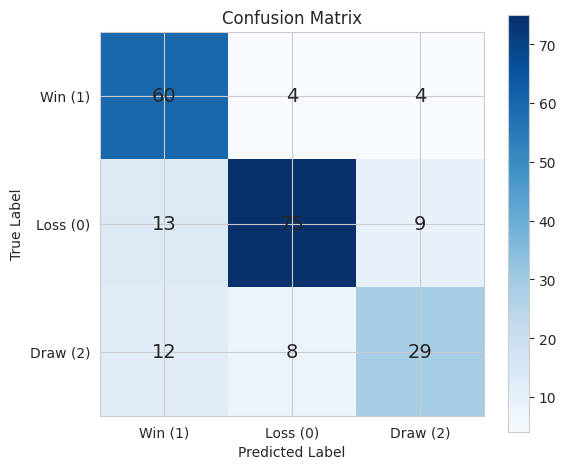

              precision    recall  f1-score   support

        Loss       0.70      0.88      0.78        69
        Draw       0.86      0.76      0.81        99
         Win       0.68      0.60      0.64        50

    accuracy                           0.76       218
   macro avg       0.75      0.75      0.74       218
weighted avg       0.77      0.76      0.76       218



In [28]:
def main():
  match_df = match_data
  elo_data = elo_df
  home_team = match_data.iloc[0]['home_team']
  away_team = match_data.iloc[0]['away_team']
  home_elo = elo_df.loc[elo_df['Team'] == home_team, 'Elo Rating'].values[0]
  away_elo = elo_df.loc[elo_df['Team'] == away_team, 'Elo Rating'].values[0]

  result = predict_all_2023_matches(match_df, elo_df)
  print(result)
  stats = grade_predictions(result, match_df)
  matches_2023 = match_df[match_df['season'] == 2023]
  confusion_matrix_plot(matches_2023['result'], result['predicted_result'])
  print(stats)

main()

## Random Forest Regression

We chose Random Forest Regression over Linear Regression because it is better suited for capturing the complex, non-linear relationships in soccer match data. The relationship between factors like goals scored, goals conceded, Elo rating, and points is not a simple straight line; winning a match awards three points, while a draw gives only one, creating abrupt jumps that a linear model would struggle to capture. Random Forest is also more robust to outliers, such as an extreme 10-0 victory, and automatically detects interactions between features, such as how a team's form and Elo rating together influence performance. Additionally, it reduces overfitting by averaging multiple decision trees, making it more reliable even with a limited dataset. By using Random Forest, we ensure our model can generalize better and provide more accurate predictions of soccer points.

In [29]:
# Encode 'Form' as the number of wins (simple approach)
new_df['Form_Wins'] = new_df['Form'].apply(lambda x: x.count('W'))

# Encode categorical variables
le = LabelEncoder()
new_df['Group'] = le.fit_transform(new_df['Group'])  # Convert Group to numbers

In [30]:
# Features & Target Selection
features = ['Group', 'Goals For', 'Goals Against', 'Goal Difference', 'Elo Rating', 'Form_Wins']
X = new_df[features]

# Regression: Predicting Points
y_reg = new_df['Points']

# Classification: Predicting Position
y_class = new_df['Position']

In [31]:
# Filter train data (2020-2022 teams) and test data (2023 teams)
train_data = new_df[new_df['Season'].isin([2020, 2021, 2022])]
test_data = new_df[new_df['Season'] == 2023]

# Extract the unique teams in the training and testing data
train_teams = train_data['Team'].unique()
test_teams = test_data['Team'].unique()

# Filter the test data to only include teams that are also in the training data
test_data_filtered = test_data[test_data['Team'].isin(train_teams)]

# Now proceed with your train-test split
X_train = train_data[features]
y_train_reg = train_data['Points']
X_test = test_data_filtered[features]
y_test_reg = test_data_filtered['Points']

In [32]:
regressor = RandomForestRegressor(random_state=42)
# Train the model
regressor.fit(X_train, y_train_reg)

# Predict on test data
y_pred_reg = regressor.predict(X_test)

# Ensure the predicted values are integers (rounding them)
y_pred_reg = np.round(y_pred_reg).astype(int)

# Evaluate the model
mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
print(f"Regression Model RMSE: {rmse}")
r2 = r2_score(y_test_reg, y_pred_reg)
print(f"Regression Model R-squared: {r2}")

Regression Model RMSE: 1.969771560359221
Regression Model R-squared: 0.8313577919268097


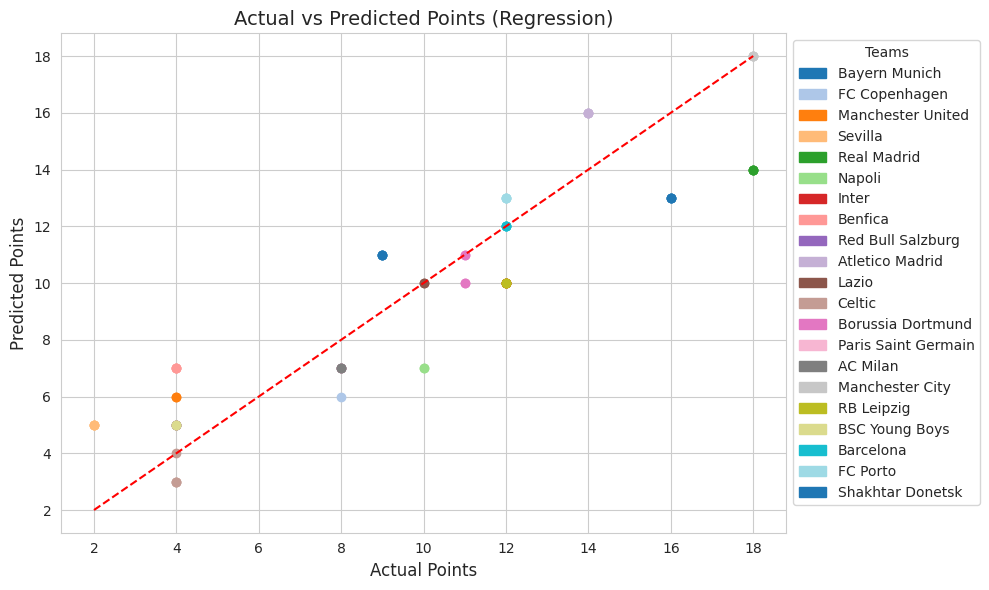

In [33]:
# Create a DataFrame to combine actual, predicted, and team names
results_df = pd.DataFrame({
    'Actual': y_test_reg,
    'Predicted': y_pred_reg,
    'Team': new_df.loc[y_test_reg.index, 'Team'].values
})

# Remove duplicates: Aggregate results by team, choosing the first occurrence for each team
# You can adjust the aggregation logic if you need to display specific results (e.g., mean)
unique_teams_df = results_df.drop_duplicates(subset='Team')

# Define a color map for teams (you can adjust this as needed)
team_colors = {team: plt.cm.tab20.colors[i % 20] for i, team in enumerate(unique_teams_df['Team'])}

# Scatter Plot of Actual vs Predicted Points
plt.figure(figsize=(10, 6))

# Create a scatter plot for each team with its respective color
for i, row in results_df.iterrows():
    team = row['Team']
    plt.scatter(row['Actual'], row['Predicted'], color=team_colors[team])

# Create a legend for each team (mapped to its color)
legend_handles = [mpatches.Patch(color=team_colors[team], label=team) for team in unique_teams_df['Team']]

# Add a red line for perfect prediction (diagonal line)
plt.plot([min(y_test_reg), max(y_test_reg)], [min(y_test_reg), max(y_test_reg)], color='red', linestyle='--')

# Title and labels
plt.title('Actual vs Predicted Points (Regression)', fontsize=14)
plt.xlabel('Actual Points', fontsize=12)
plt.ylabel('Predicted Points', fontsize=12)
plt.grid(True)

# Add the legend to the plot
plt.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1, 1), title="Teams")

# Show the plot
plt.tight_layout()
plt.show()

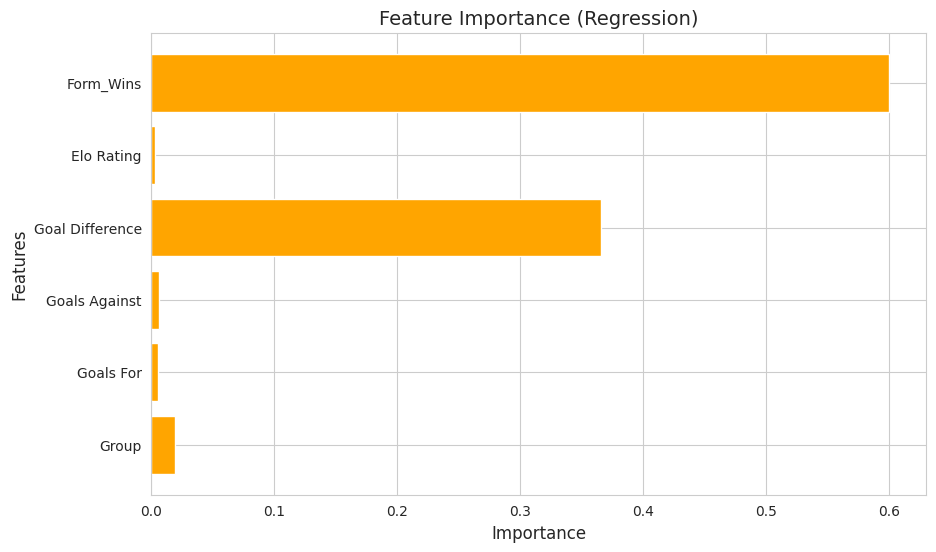

In [34]:
# Feature Importance for Regression
feature_importances = regressor.feature_importances_
features = X.columns

# Bar plot for feature importances
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances, color='orange')
plt.title('Feature Importance (Regression)', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()

## RandomForestClassifier

In [35]:
# Filter train data (2020-2022 teams) and test data (2023 teams)
train_data = new_df[new_df['Season'].isin([2020, 2021, 2022])]
test_data = new_df[new_df['Season'] == 2023]

# Extract the unique teams in the training and testing data
train_teams = train_data['Team'].unique()
test_teams = test_data['Team'].unique()

# Filter the test data to only include teams that are also in the training data
test_data_filtered = test_data[test_data['Team'].isin(train_teams)]

# Features and target selection for classification
X_train_class = train_data[features]
y_train_class = train_data['Position']
X_test_class = test_data_filtered[features]
y_test_class = test_data_filtered['Position']

In [36]:
# Classification Model: RandomForestClassifier
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train_class, y_train_class)

# Predicting on test data
y_pred_class = classifier.predict(X_test_class)

# Evaluating the model
accuracy = classification_report(y_test_class, y_pred_class) #precision recall and stuff
print(f"Classification Model Accuracy: {accuracy}")

Classification Model Accuracy:               precision    recall  f1-score   support

           1       0.92      0.96      0.94        24
           2       0.76      0.73      0.74        22
           3       0.67      0.71      0.69        14
           4       0.86      0.80      0.83        15

    accuracy                           0.81        75
   macro avg       0.80      0.80      0.80        75
weighted avg       0.81      0.81      0.81        75



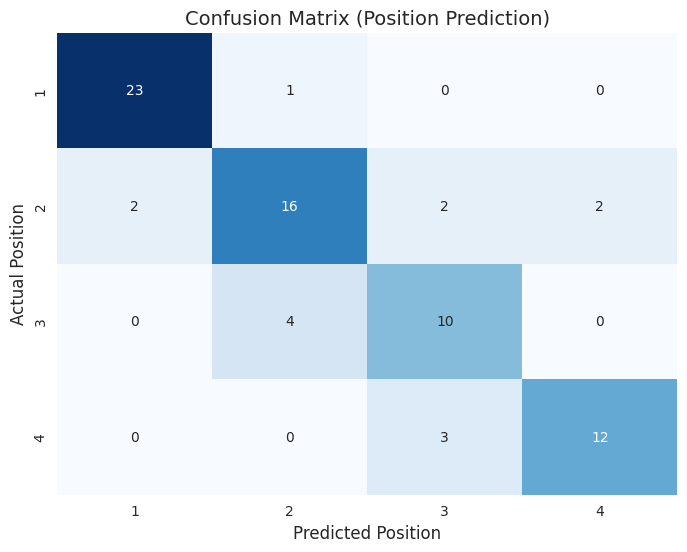

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_test_class, y_pred_class)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=range(1, 5), yticklabels=range(1, 5))
plt.title('Confusion Matrix (Position Prediction)', fontsize=14)
plt.xlabel('Predicted Position', fontsize=12)
plt.ylabel('Actual Position', fontsize=12)
plt.show()

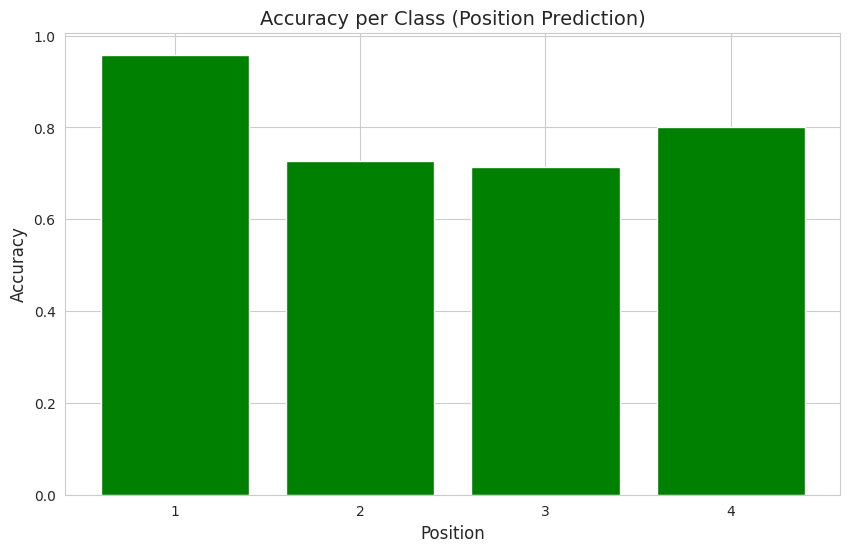

In [38]:
# Accuracy per Class (Position)
accuracy_per_class = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(accuracy_per_class) + 1), accuracy_per_class, color='green')
plt.title('Accuracy per Class (Position Prediction)', fontsize=14)
plt.xlabel('Position', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(range(1, len(accuracy_per_class) + 1))
plt.show()

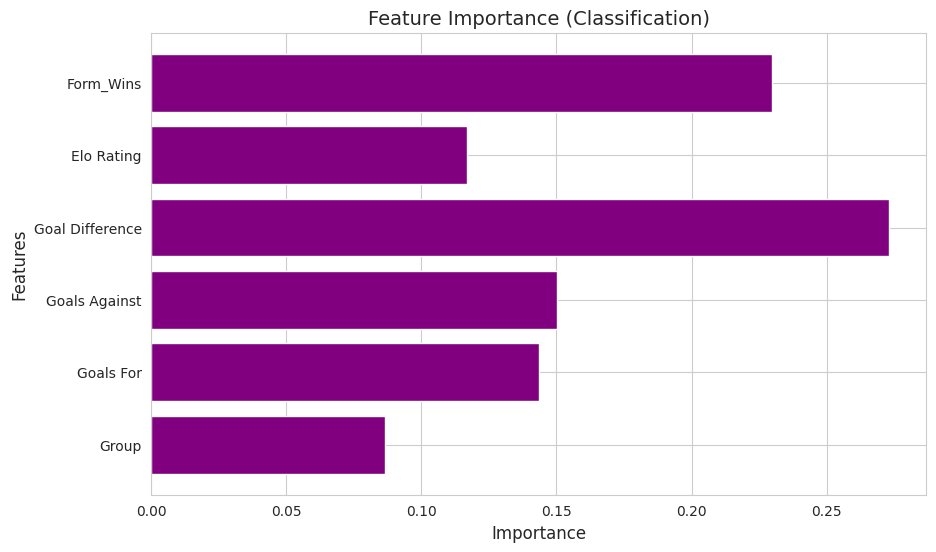

In [39]:
# Feature Importance for Classification
feature_importances_class = classifier.feature_importances_

# Bar plot for feature importances
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances_class, color='purple')
plt.title('Feature Importance (Classification)', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()

For the 2023 dataset, 4 teams are not included because they had no prior data in the last 3 year worth of champions league data, so you cannot predict them if they have no prior data.

## Initial Approach

Our original question for the project was, *“Can AI predict the outcome of the 2023 Champions League?”. However, after extensive testing we adjusted this to the question , "How well can AI predict the group stage of the 2023 Champions league?". We wanted to see if we could use stats to predict how teams would perform and maybe even guess the scores for some of the matches. At first, we planned to collect all our data through web scraping, but after the site we were using blocked scraping, we had to switch plans. We ended up using API-Football, which gave us access to useful data about Champions League teams and matches.

We focused on two types of predictions: regression to predict how many points each team would earn, and classification to predict their final group position. We used features like goals scored, goals against, goal difference, Elo rating, and recent form. We trained the models on data from 2020 to 2022 and tested on 2023 teams that had appeared in earlier seasons to see how our models performed on new data.

As a note on the ethicality, some teams that have no history in the Champions League may not be represented because they have no past data so in our regression they may not be present due to the lack of data to predict on. This means that some teams have no representation in the machine learning model creating a bias against them.

## Model 1: KNN

Our first model was KNN to predict the outcome of the 2023 champions league group stage. The main feature used to predict was elo_rating since it was the easiest and was a good way of grading team strength. Our accuracy when classifying the 2023 champions league groups stage with this was 76%. Considering how broad of statistic ELO is, this is a really good accuracy and we are very pleased with it. Our confusion table shows that our model is overpredicting teams winning.



## Model 2: Random Forest Regression Regression

Our second model was a Random Forest Regressor to predict how many points each team would earn in the group stage. It used features like goal difference, Elo rating, and Form_Wins to capture team quality and recent performance. The model had a Root Mean Squared Error (RMSE) of 1.91 and an R² score of 0.837, which shows strong performance overall. Most of the predicted points were very close to the actual values, especially for stronger teams like Manchester City and Bayern Munich. There were a few small errors for lower-performing teams, but nothing major. The actual vs. predicted points plot confirmed that the model followed the correct trends.


## Conclusions

Our models did a solid job predicting how teams would perform in the 2023 Champions League group stage. The regression model explained most of the variation in points, while the classification model accurately predicted final positions in most cases. The results showed that goal difference and recent form were the most important stats for prediction.

In the future, we could try other models or add more detailed match stats like possession and shots. Improving class balance could also help with the weaker 4th place predictions. Overall, the project showed that AI can give pretty accurate predictions and has potential for even better results with more data and refinement.
